In [31]:
!pip install torchmetrics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import os
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from tqdm import tqdm  # For progress bar

# For visualiztions
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import roc_curve, auc

data_path = '/content/drive/My Drive/AI4ALL Diabetic Retinopathy Research/Early ML Model/aptos2019-blindness-detection'
csv_file = os.path.join(data_path, 'train.csv')
print(csv_file)

Mounted at /content/drive
/content/drive/My Drive/AI4ALL Diabetic Retinopathy Research/Early ML Model/aptos2019-blindness-detection/train.csv


In [ ]:
NUM_CLASSES = 5
INPUT_SIZE = (224, 224)
PATCH_SIZE = (16, 16)
IN_CHANNELS = 3
RANDOM_SEED = 0
TRAIN_SPLIT_FRAC = 0.8

class Aptos(Dataset):
  def __init__(self, csv_file, root_dir):
      self.data_frame = pd.read_csv(csv_file)
      self.root_dir = root_dir
      self.transform = transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(10),
       # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),])

  def __len__(self):
      return len(self.data_frame)

  def __getitem__(self, idx):
      img_name = os.path.join(self.root_dir, 'train_images', self.data_frame.iloc[idx, 0] + '.png')
      image = Image.open(img_name).convert('RGB')
      label = self.data_frame.iloc[idx, 1]

      if self.transform:
          image = self.transform(image)

      return image, label

# Loading Data

In [ ]:
dataset = Aptos(csv_file=csv_file, root_dir=data_path)

# Splitting
train_dataset, valid_dataset = torch.utils.data.random_split(dataset, [int(len(dataset)*TRAIN_SPLIT_FRAC), len(dataset) - int(len(dataset)*TRAIN_SPLIT_FRAC)])

# Loading
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


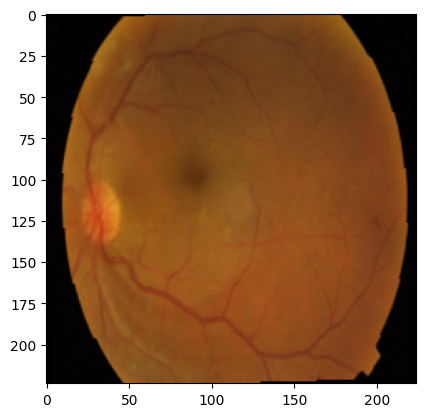

Label: 1


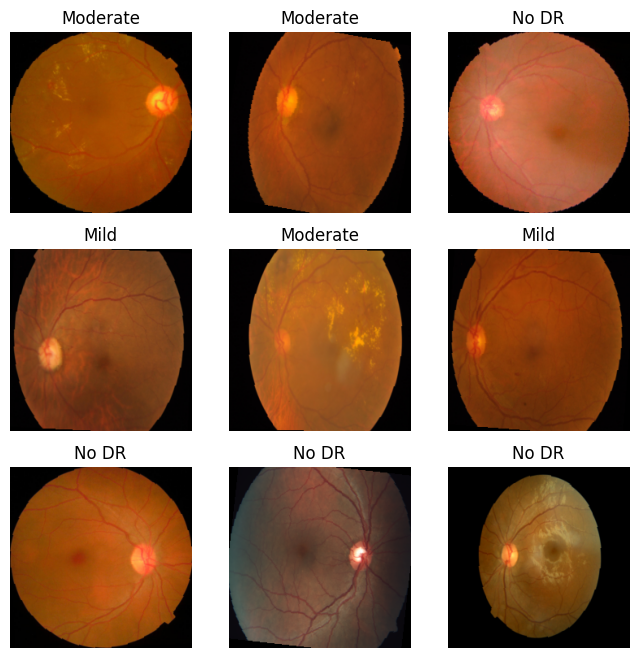

In [ ]:
train_features, train_labels = next(iter(train_dataloader))

print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

img = train_features[0].squeeze()
label = train_labels[0]
img = img.permute(1, 2, 0)
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

labels_map = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative DR",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3

# Randomized dataloader visual
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    img, label = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1, 2, 0), cmap="gray")
plt.show()

# CNN Model

In [ ]:
class CNN(nn.Module):

    def __init__(self):
        super(CNN, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # get in_features from error
        self.fc1 = nn.Linear(in_features=193600, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=5)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)

        return out

In [ ]:
model = CNN()
model.to('cpu')

error = nn.CrossEntropyLoss()

learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
print(model)

CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=193600, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=5, bias=True)
)


# Training + Testing

In [34]:
import time
import torchmetrics
from torch import tensor
from torchmetrics.classification import MulticlassAUROC
from torchmetrics.classification import MulticlassF1Score

# Lists for visualization of loss and accuracy
train_loss_list = []
train_accuracy_list = []
train_iteration_list = []

valid_loss_list = []
valid_accuracy_list = []
valid_iteration_list = []

train_loss_epoch_list = []
train_accuracy_epoch_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []
# device = 'cpu'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_tp, train_tn, train_fp, train_fn = [], [], [], []
valid_tp, valid_tn, valid_fp, valid_fn = [], [], [], []

train_aurocs = []
valid_aurocs = []
train_f1s, valid_f1s = [], []

def train(model, train_loader, valid_loader, criterion, optimizer, epochs=5):

    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []
    count = 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct, total = 0, 0
        all_train_labels, all_train_preds = [], []
        start_time = time.time()

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # For loss/accuracy graph
            train_loss_list.append(loss.item())
            train_accuracy_list.append(100 * correct / total)
            train_iteration_list.append(count)
            count += 1

            all_train_labels.extend(labels.cpu().numpy())
            all_train_preds.extend(torch.softmax(outputs, dim=1).detach().cpu().numpy())

            # save auroc multi in list
            metric = MulticlassAUROC(num_classes=5, average="macro", thresholds=None)
            train_aurocs.append(metric(outputs, labels))

            f1_metric = MulticlassF1Score(num_classes=5, average="macro")
            train_f1s.append(f1_metric(outputs, labels))

        # TP, TN, FP, FN for Confusion Matrix
        cm = confusion_matrix(all_train_labels, np.argmax(all_train_preds, axis=1))
        tp = np.diag(cm)
        fn = np.sum(cm, axis=1) - tp
        fp = np.sum(cm, axis=0) - tp
        tn = np.sum(cm) - (tp + fn + fp)
        train_tp.append(tp)
        train_tn.append(tn)
        train_fp.append(fp)
        train_fn.append(fn)

        # Updating running loss and accuracy
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

  # Validation
        # loss, accuracy, f1s, aurocs
        valid_loss, valid_accuracy, valid_auroc, valid_f1, valid_tp_epoch, valid_tn_epoch, valid_fp_epoch, valid_fn_epoch, all_valid_labels, all_valid_preds = validate(model, valid_loader, criterion)
        valid_losses.append(valid_loss)
        valid_accuracies.append(valid_accuracy)

        # TP, TN, FP, FN for Confusion Matrix
        valid_tp.append(valid_tp_epoch)
        valid_tn.append(valid_tn_epoch)
        valid_fp.append(valid_fp_epoch)
        valid_fn.append(valid_fn_epoch)

        curr = time.ctime(time.time())
        print("--- %s seconds ---" % (time.time() - start_time))
        print(f"Epoch {epoch+1}, Train Loss: {round(train_loss, 5)}, Train Accuracy: {round(train_accuracy, 5)}%, Valid Loss: {round(valid_loss, 5)}, Valid Accuracy: {round(valid_accuracy, 5)}%")

    return (train_losses, valid_losses, train_accuracies, valid_accuracies,
            train_aurocs, valid_aurocs,
            train_tp, train_tn, train_fp, train_fn,
            valid_tp, valid_tn, valid_fp, valid_fn)

def validate(model, valid_loader, criterion):
    model.eval()
    running_loss = 0.0
    correct, total = 0, 0
    count = 0
    all_valid_labels, all_valid_preds = [], []

    with torch.no_grad():
        for inputs, labels in valid_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_valid_labels.extend(labels.cpu().numpy())
            all_valid_preds.extend(torch.softmax(outputs, dim=1).cpu().numpy())

            metric = MulticlassAUROC(num_classes=5, average="macro", thresholds=None)
            valid_aurocs.append(metric(outputs, labels))

            f1_metric = MulticlassF1Score(num_classes=5, average="macro")
            valid_f1s.append(f1_metric(outputs, labels))

            # For loss/accuracy graph
            valid_loss_list.append(loss.item())
            valid_accuracy_list.append(100 * correct / total)
            valid_iteration_list.append(count)
            count += 1

    valid_loss = running_loss / len(valid_loader)
    valid_accuracy = 100 * correct / total
    """all_valid_labels = np.array(all_valid_labels)
    all_valid_preds = np.array(all_valid_preds)
    valid_auroc = roc_auc_score(all_valid_labels, all_valid_preds, multi_class='ovr') if len(np.unique(all_valid_labels)) > 1 else float('nan')
    valid_f1 = f1_score(all_valid_labels, np.argmax(all_valid_preds, axis=1), average='weighted')"""

    # TP, TN, FP, FN for Confusion Matrix
    cm = confusion_matrix(all_valid_labels, np.argmax(all_valid_preds, axis=1))
    tp = np.diag(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)

    return valid_loss, valid_accuracy, valid_aurocs, valid_f1s, tp, tn, fp, fn, all_valid_labels, all_valid_preds

train_losses, valid_losses, train_accuracies, valid_accuracies, train_aurocs, valid_aurocs, train_tp, train_tn, train_fp, train_fn, valid_tp, valid_tn, valid_fp, valid_fn = train(model, train_dataloader, valid_dataloader, criterion, optimizer, epochs=1)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:1374: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
/usr/local/lib/python3.10/dist-packages/torchmetrics

--- 1060.3441262245178 seconds ---
Epoch 1, Train Loss: 0.762, Train Accuracy: 72.48208%, Valid Loss: 0.84098, Valid Accuracy: 72.98772%


# Visualizations

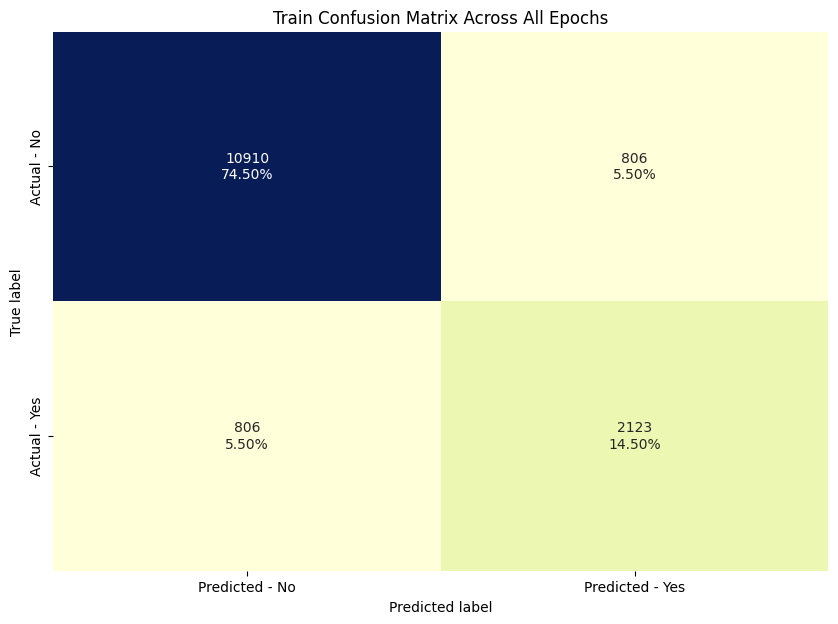

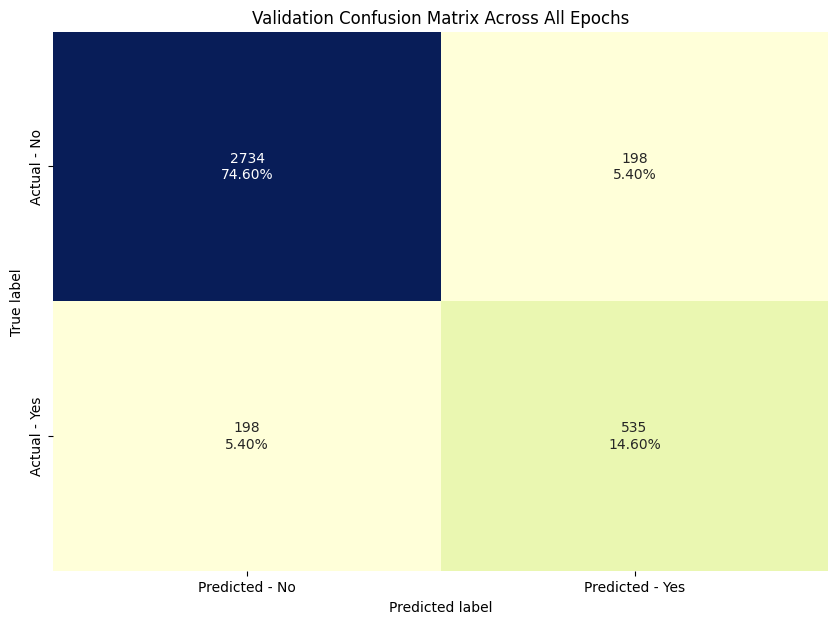

In [35]:
import seaborn as sns

def make_confusion_matrix(train_tp, train_tn, train_fp, train_fn, type, labels=['No', 'Yes']):
    # Calculate metrics from TP, TN, FP, FN
    cm = np.array([[np.sum(train_tn), np.sum(train_fp)],
                   [np.sum(train_fn), np.sum(train_tp)]])

    # Create DataFrame for confusion matrix
    df_cm = pd.DataFrame(cm, index=[f'Actual - {labels[0]}', f'Actual - {labels[1]}'],
                         columns=[f'Predicted - {labels[0]}', f'Predicted - {labels[1]}'])

    # Create annotations for each cell
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)

    # Plotting the heatmap with adjusted color scheme
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=labels, fmt='', cmap='YlGnBu', cbar=False)  # Change 'cmap' to adjust the color scheme
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.title(f'{type} Confusion Matrix Across All Epochs')
    plt.show()


make_confusion_matrix(train_tp, train_tn, train_fp, train_fn, "Train")
make_confusion_matrix(valid_tp, valid_tn, valid_fp, valid_fn, "Validation")

In [ ]:
print("valid accuracy", valid_accuracy_list)
print("valid loss", valid_loss_list)
print(len(valid_accuracy_list))
print(len(valid_loss_list))
print(valid_iteration_list)

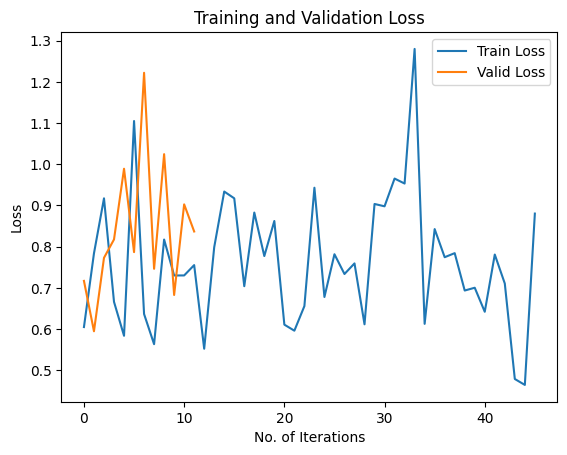

In [36]:
plt.plot(train_loss_list, label='Train Loss')
plt.plot(valid_loss_list, label='Valid Loss')
plt.xlabel('No. of Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

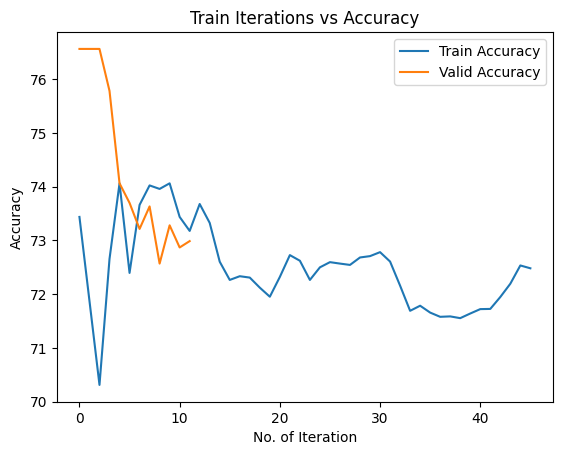

In [37]:
plt.plot(train_accuracy_list, label='Train Accuracy')
plt.plot(valid_accuracy_list, label='Valid Accuracy')
plt.xlabel("No. of Iteration")
plt.ylabel("Accuracy")
plt.title("Train Iterations vs Accuracy")
plt.legend()

In [48]:
def calculate_tpr_fpr(tp, fp, tn, fn):
  tpr = []
  fpr = []
  for i in range(len(tp)):
      print(i)
      tpr.append(tp[i]/(tp[i]+fn[i]))
      fpr.append(fp[i]/(fp[i]+tn[i]))

  return tpr, fpr

def calculate_accuracy_precision_recall_specificity(tp, fp, tn, fn):
  tp = np.array(tp)
  fp = np.array(fp)
  tn = np.array(tn)
  fn = np.array(fn)

  accuracy = (tp+tn)/(tp+tn+fp+fn)
  precision = tp/(tp+fp)
  recall = tp/(tp+fn)
  specificity = tn/(tn+fp)

  return accuracy, precision, recall, specificity

train_tpr, train_fpr = calculate_tpr_fpr(train_tp, train_fp, train_tn, train_fn)
valid_tpr, valid_fpr = calculate_tpr_fpr(valid_tp, valid_fp, valid_tn, valid_fn)

train_acc, train_prec, train_recall, train_sp = calculate_accuracy_precision_recall_specificity(train_tp, train_fp, train_tn, train_fn)
valid_acc, valid_prec, valid_recall, valid_sp = calculate_accuracy_precision_recall_specificity(train_tp, train_fp, train_tn, train_fn)

0
0


In [56]:
print(train_tp)
print(train_acc)
print(train_prec)
print(train_recall)

[array([1389,  123,  564,   26,   21])]
[[0.92796176 0.88938204 0.78559235 0.93308296 0.9136224 ]]
[[0.90312094 0.45220588 0.57965057 0.2826087  0.38888889]]
[[0.95727085 0.41275168 0.72030651 0.16666667 0.08713693]]


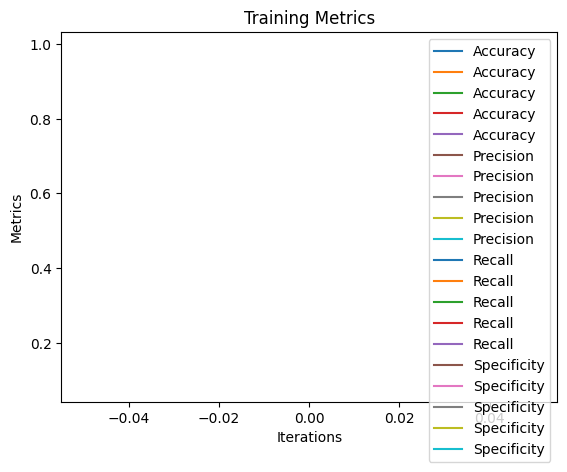

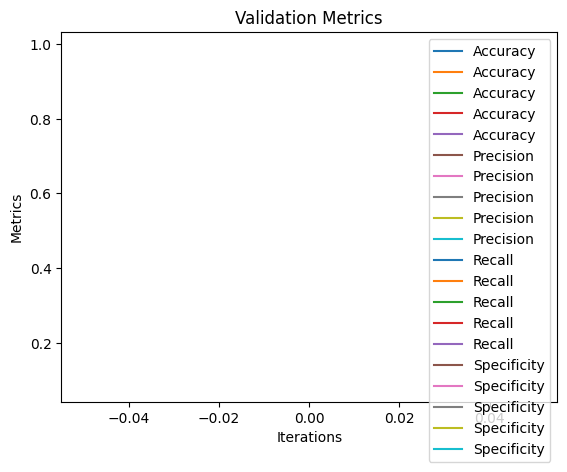

In [58]:
plt.plot(train_acc, label='Accuracy')
plt.plot(train_prec, label='Precision')
plt.plot(train_recall, label='Recall')
plt.plot(train_sp, label='Specificity')
plt.xlabel('Iterations')
plt.ylabel('Metrics')
plt.title('Training Metrics')
plt.legend()
plt.show()

plt.plot(valid_acc, label='Accuracy')
plt.plot(valid_prec, label='Precision')
plt.plot(valid_recall, label='Recall')
plt.plot(valid_sp, label='Specificity')
plt.xlabel('Iterations')
plt.ylabel('Metrics')
plt.title('Validation Metrics')
plt.legend()

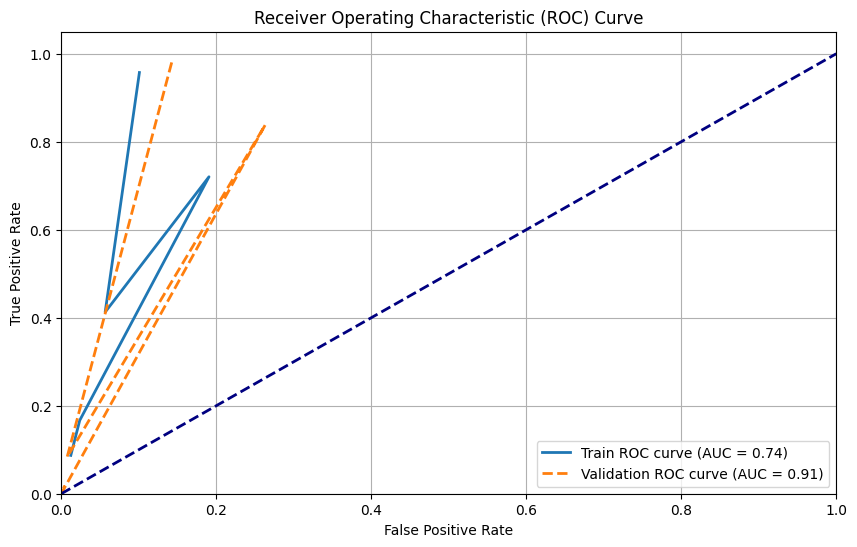

In [41]:
plt.figure(figsize=(10, 6))
for i in range(len(train_fpr)):
    plt.plot(train_fpr[i], train_tpr[i], lw=2, label=f'Train ROC curve (AUC = {train_aurocs[i]:.2f})')
for i in range(len(valid_fpr)):
    plt.plot(valid_fpr[i], valid_tpr[i], lw=2, linestyle='--', label=f'Validation ROC curve (AUC = {valid_aurocs[i]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

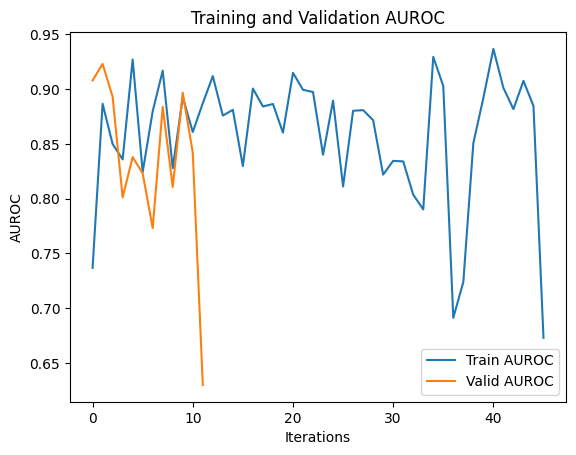

In [42]:
plt.plot(train_aurocs, label='Train AUROC')
plt.plot(valid_aurocs, label='Valid AUROC')
plt.xlabel('Iterations')
plt.ylabel('AUROC')
plt.title('Training and Validation AUROC')
plt.legend()

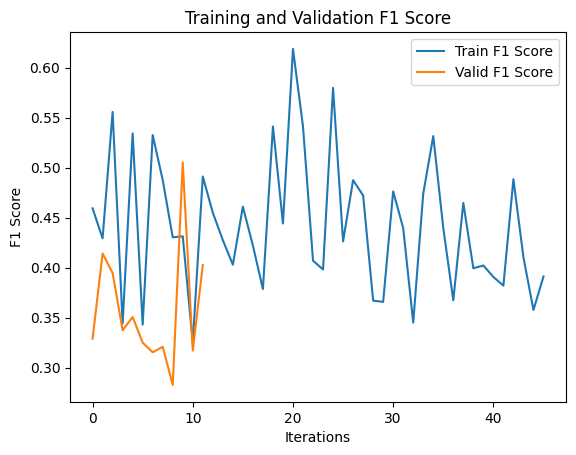

In [43]:
plt.plot(train_f1s, label='Train F1 Score')
plt.plot(valid_f1s, label='Valid F1 Score')
plt.xlabel('Iterations')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()

In [44]:
valid_f1s

[tensor(0.3289),
 tensor(0.4142),
 tensor(0.3946),
 tensor(0.3373),
 tensor(0.3507),
 tensor(0.3250),
 tensor(0.3154),
 tensor(0.3209),
 tensor(0.2827),
 tensor(0.5052),
 tensor(0.3170),
 tensor(0.4026)]